[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/network_architecture_visualization.ipynb)

# Network Architecture Visualization

Understanding the Model Architecture might be really helpful for both debugging your network or understanding its behaviour.

In this notebook, we will build a global model using data from the hourly load of the ERCOT region. We will use as reference the notebook `./global_modeling.ipynb`

Finally, we will visualize the network's architecture.



First we will install graphviz. For windows go to https://www.graphviz.org/download/.
For Mac/Linux run the command below


In [ ]:
try:
    # it already installed dependencies
    from torchsummary import summary
    from torchviz import make_dot
except ImportError:
    # install graphviz on system
    import platform

    if "Darwin" == platform.system():
        !brew install graphviz
    elif "Linux" == platform.system():
        !sudo apt install graphviz
    else:
        print("go to  https://www.graphviz.org/download/")
    # Next we need to install the following dependencies:
    !pip install torchsummary
    !pip install torch-summary
    !pip install torchviz
    !pip install graphviz
    # import
    from torchsummary import summary
    from torchviz import make_dot

In [2]:
try:
    from neuralprophet import NeuralProphet
except ImportError:
    # if NeuralProphet is not installed yet:
    !pip install git+https://github.com/ourownstory/neural_prophet.git
    from neuralprophet import NeuralProphet

In [3]:
import pandas as pd
from neuralprophet import set_log_level

set_log_level("ERROR")

First, we load the data:



In [4]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head(3)

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42


We extract the name of the regions which will be later used in the model creation.

In [5]:
regions = list(df_ercot)[1:]

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [6]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[["ds", col]].copy(deep=True)  # select column associated with region
    aux = aux.iloc[:26301, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
    aux["ID"] = col
    df_global = pd.concat((df_global, aux))
df_global.head(3)

,ds,y,ID
0,2004-01-01 01:00:00,7225.09,COAST
1,2004-01-01 02:00:00,6994.25,COAST
2,2004-01-01 03:00:00,6717.42,COAST


When a pd.DataFrame with an 'ID' column is the input for the `split_df` function, train and validation data are provided in a similar format. For global models, the input data is typically split according to a fraction of the time encompassing all time series (default when there is more than one 'ID' and when `local_split=False`). If the user wants to split each time series locally, the `local_split` parameter must be set to True. In this example, we will split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

Global modeling lets us train our model based on a global or a local normalization. In the latter, each time series is normalized locally (each time series has its respective data params). In the former, we have unique data params which will be used in all the time series at hand.

## Global Modeling - Local Normalization

In [7]:
m = NeuralProphet(n_lags=24, epochs=2, learning_rate=0.1)
df_train, df_test = m.split_df(df_global, valid_p=0.33, local_split=True)

The default fitting of global models is based on local data normalization. Each time series will have data normalization parameters associated with each 'ID' provided. We are going to define a model which predicts the next hour based on the last 24 hours.

After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

In [8]:
metrics = m.fit(df_train, freq="H")
metrics.tail(1)

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
1,0.025526,0.033126,0.000416,0.0,1


### 1. Network Summary
From https://pypi.org/project/torch-summary/ :

Torch-summary provides information complementary to what is provided by `print(your_model)` in PyTorch, similar to Tensorflow's `model.summary()` API to view the visualization of the model, which is helpful while debugging your network. In this project, we implement a similar functionality in PyTorch and create a clean, simple interface to use in your projects.`


In [9]:
display(summary(m.model))

Layer (type:depth-idx)                   Param #
├─MetricCollection: 1-1                  --
|    └─MeanAbsoluteError: 2-1            --
|    └─MeanSquaredError: 2-2             --
├─MetricCollection: 1-2                  --
|    └─MeanAbsoluteError: 2-3            --
|    └─MeanSquaredError: 2-4             --
├─GlobalPiecewiseLinearTrend: 1-3        13
├─GlobalFourierSeasonality: 1-4          --
|    └─ParameterDict: 2-5                30
├─ModuleList: 1-5                        --
|    └─Linear: 2-6                       24
Total params: 67
Trainable params: 67
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─MetricCollection: 1-1                  --
|    └─MeanAbsoluteError: 2-1            --
|    └─MeanSquaredError: 2-2             --
├─MetricCollection: 1-2                  --
|    └─MeanAbsoluteError: 2-3            --
|    └─MeanSquaredError: 2-4             --
├─GlobalPiecewiseLinearTrend: 1-3        13
├─GlobalFourierSeasonality: 1-4          --
|    └─ParameterDict: 2-5                30
├─ModuleList: 1-5                        --
|    └─Linear: 2-6                       24
Total params: 67
Trainable params: 67
Non-trainable params: 0

### 2. Network Vizualisation

From https://github.com/szagoruyko/pytorchviz :

A small package to create visualizations of PyTorch execution graphs and traces.


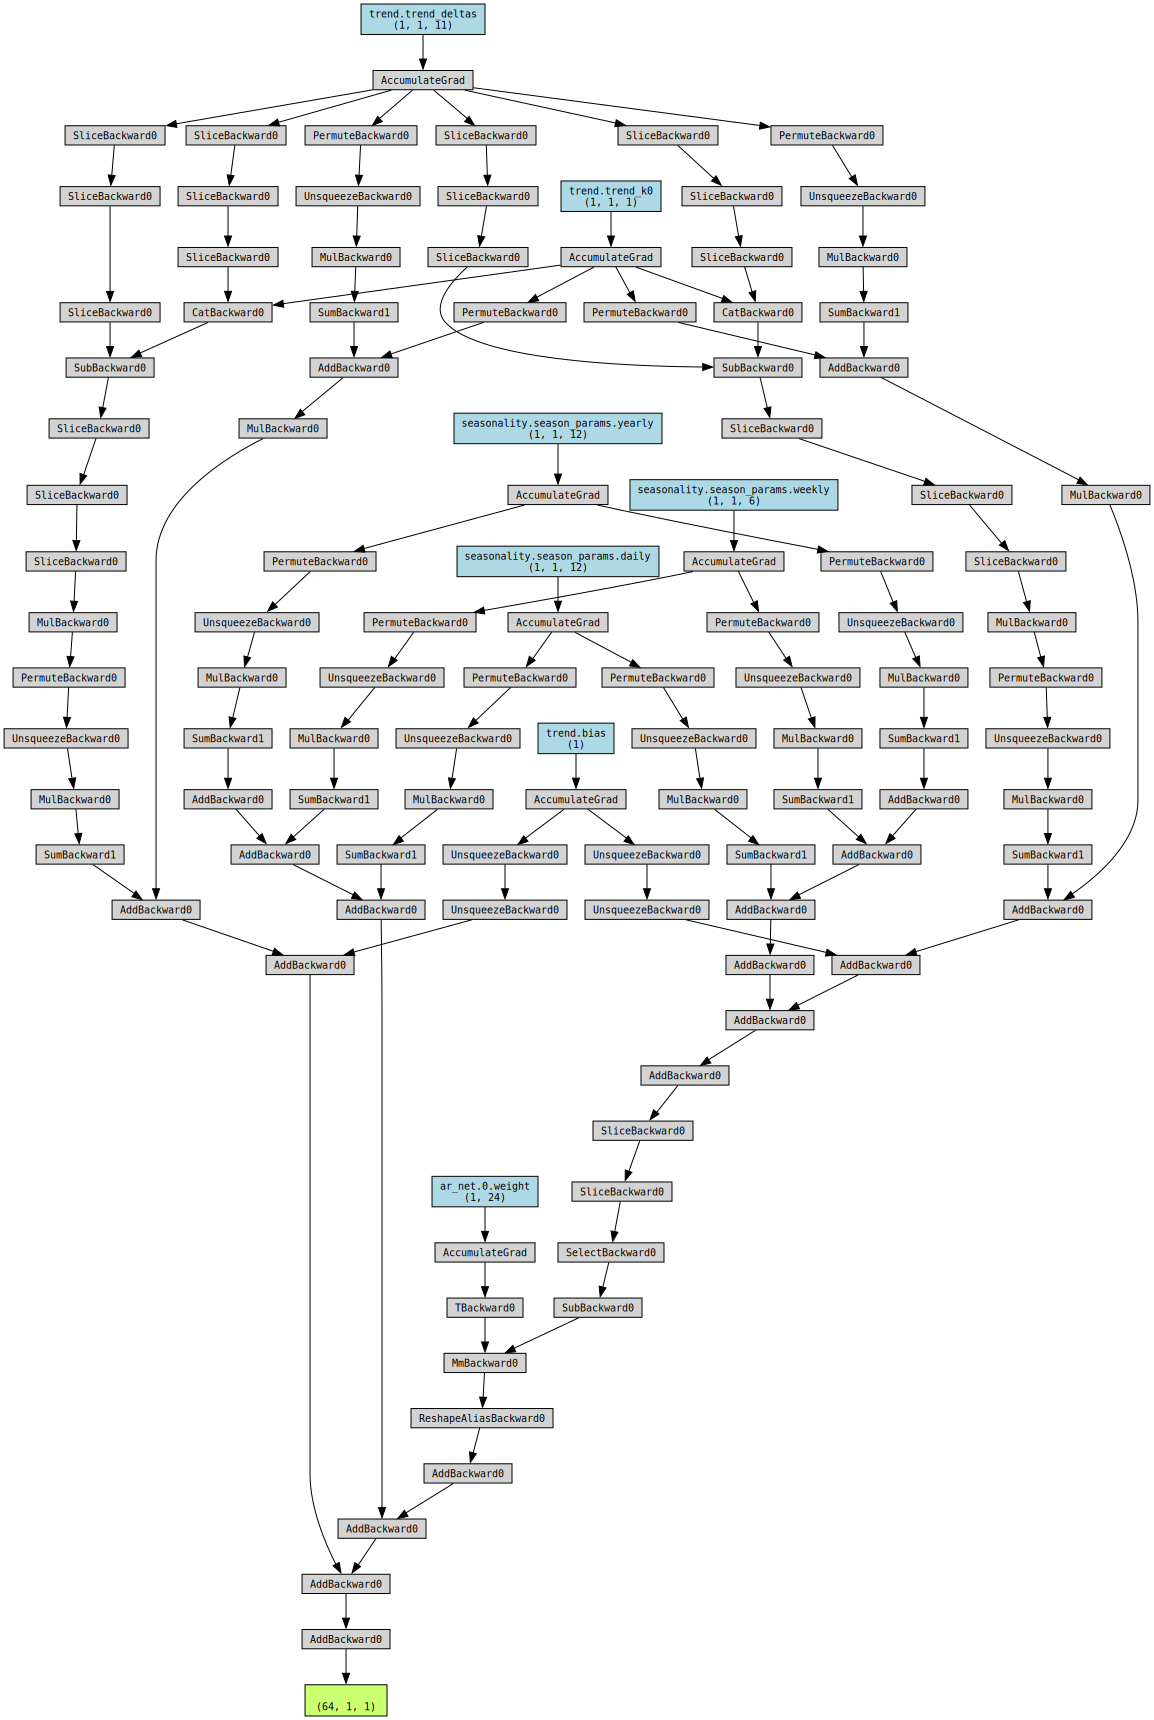

In [10]:
fig = make_dot(m.model.train_epoch_prediction, params=dict(m.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)